# Develop a Chatbot Using Python, NLTK, and TensorFlow

In [25]:
# Run this cell so you do not see GPU availibility errors from tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### Task 1: Import the Required Libraries

In [26]:
import json
import pickle
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
import matplotlib.pyplot as plt

### Task 2: Load the Data

In [27]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) 
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)

with open('intents.json') as data:
    intents = json.loads(data.read())

### Task 3: Tokenization

In [28]:
# Initialize necessary lists
words = []
unique_intents = []
documents = []

for intent in intents['intents']:
    for pattern in intent['patterns']:
        w = nltk.word_tokenize(pattern) 
        words.extend(w)
        documents.append((w, intent['tag']))
        if intent['tag'] not in unique_intents:
            unique_intents.append(intent['tag'])

### Task 4: Lemmatization

In [29]:
lemmatizer=WordNetLemmatizer()
ignore_words = ['?', '!', '.', ',']
stop_words = set(stopwords.words('english'))  # Add stopwords for better preprocessing

# Lemmatize and remove stopwords
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words and w.lower() not in stop_words]

# Remove duplicates & sort words and classes
words = sorted(set(words))
classes = sorted(set(unique_intents))

# Save processed words
with open('words.pkl', 'wb') as file:
    pickle.dump(words, file)

# Save processed classes
with open('classes.pkl', 'wb') as file:
    pickle.dump(classes, file)


### Task 5: Create Data for Training

In [30]:
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in doc[0]]
    bag = [1 if w in pattern_words else 0 for w in words]
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype='object')

X_train = list(training[:, 0])
y_train = list(training[:, 1])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to TensorFlow dataset for training
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32)


### Task 6: Design the Model

In [31]:
model = Sequential([
    Dense(256, input_shape=(len(X_train[0]),), activation='relu'), # input layer and first hidden layer
    Dropout(0.3), # first dropout layer
    Dense(128, activation='relu'), # second hidden layer
    Dropout(0.3), # second dropout layer
    Dense(64, activation='relu'), # third hidden layer
    # Output layer
    Dense(len(y_train[0]), activation='softmax')
])


### Task 7: Train and Save the Model

In [32]:
model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.001), 
            metrics=['accuracy'])

# Train the Model
history = model.fit(
                    train_data, 
                    epochs=200, verbose=1,
                    validation_data=(X_val, y_val))

# Save the Model
model.save('trained_model.h5')

Epoch 1/200
2/2 [==============================] - 1s 238ms/step - loss: 2.5734 - accuracy: 0.0769 - val_loss: 2.5909 - val_accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 0s 30ms/step - loss: 2.5348 - accuracy: 0.0962 - val_loss: 2.5867 - val_accuracy: 0.0000e+00
Epoch 3/200
2/2 [==============================] - 0s 48ms/step - loss: 2.4933 - accuracy: 0.1923 - val_loss: 2.5836 - val_accuracy: 0.0000e+00
Epoch 4/200
2/2 [==============================] - 0s 55ms/step - loss: 2.4628 - accuracy: 0.2692 - val_loss: 2.5828 - val_accuracy: 0.0000e+00
Epoch 5/200
2/2 [==============================] - 0s 47ms/step - loss: 2.4616 - accuracy: 0.2500 - val_loss: 2.5819 - val_accuracy: 0.0000e+00
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 2.4083 - accuracy: 0.2885 - val_loss: 2.5815 - val_accuracy: 0.0000e+00
Epoch 7/200
2/2 [==============================] - 0s 35ms/step - loss: 2.3857 - accuracy: 0.3654 - val_loss: 2.5825 - val_accuracy: 0.

/home/emac/PROJETS_PERSO/first-chatbot/venv_10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Task 8: Print the Training Curves

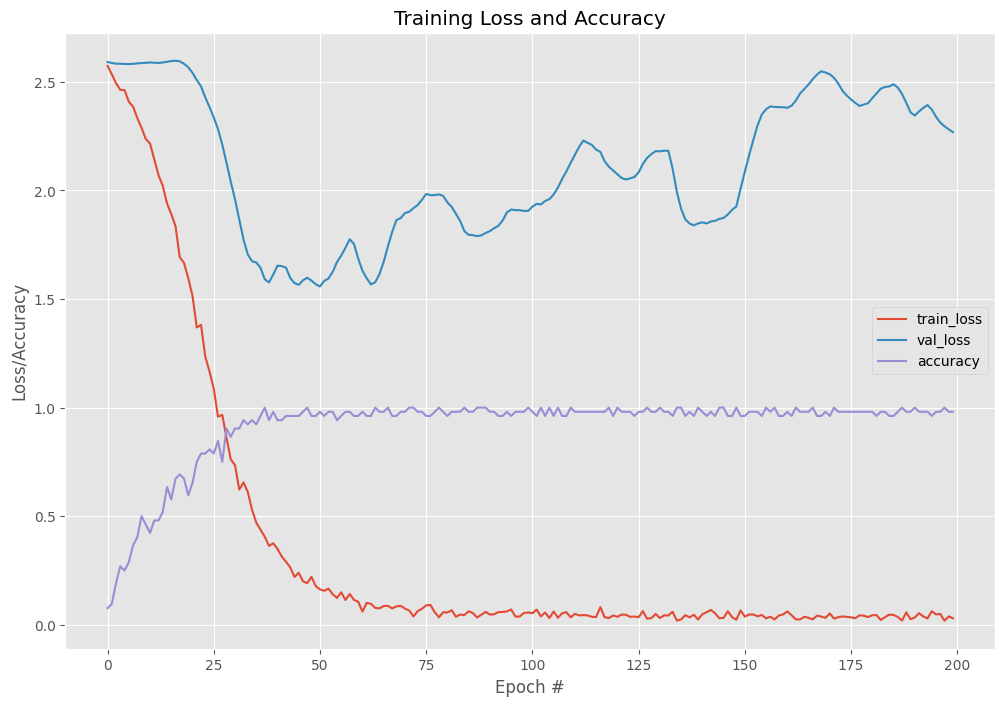

In [33]:
plt.rcParams["figure.figsize"] = (12, 8)
epochs = np.arange(0, 200)
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs, history.history["loss"], label="train_loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.plot(epochs, history.history["accuracy"], label="accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()